## Inteligência Artificial 2024.1: Prova N1 - 1o Bimestre

### Nome: Carlos Eduardo Vieira Santos

### R.A.: 081200016

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from numpy.typing import NDArray

## Base de dados:

#### Carregamento dos dados:

In [90]:
base = pd.read_excel("Base_N1_B1_2024.1.xlsx")
base.head()

,Feature1,Feature2,Label
0,0.000,5.472986,Red
1,0.005,4.326074,Red
2,0.010,5.257439,Red
3,0.015,3.321764,Red
4,0.020,5.783143,Red


In [91]:
base.describe()

,Feature1,Feature2
count,800.000000,800.000000
mean,1.072500,3.588866
std,0.582564,3.133176
min,0.000000,-3.353179
25%,0.573750,0.712466
50%,1.072500,3.553948
75%,1.571250,6.438598
max,2.145000,9.963324


In [92]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  800 non-null    float64
 1   Feature2  800 non-null    float64
 2   Label     800 non-null    object 
dtypes: float64(2), object(1)
memory usage: 18.9+ KB


In [93]:
base["Label"].value_counts()

Red     400
Blue    400
Name: Label, dtype: int64

In [94]:
base["Bias"] = 1
df_red = base.loc[base["Label"] == "Red", ["Bias", "Feature1", "Feature2"]].copy()
df_blue = base.loc[base["Label"] == "Blue", ["Bias", "Feature1", "Feature2"]].copy()

#### Distribuição dos dados:

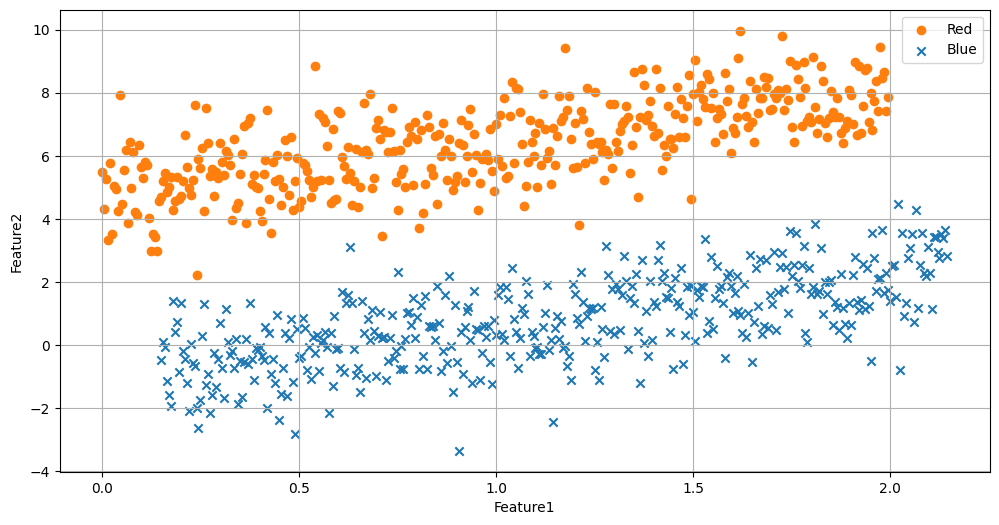

In [95]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_red["Feature1"], df_red["Feature2"], marker="o", color="tab:orange", label="Red"
)
plt.scatter(
    df_blue["Feature1"], df_blue["Feature2"], marker="x", color="tab:blue", label="Blue"
)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.grid()
plt.legend()
plt.show()

## Desenvolvimento do classificador:

#### Classe genérica com funções úteis:

In [104]:
class Classifier:
    """Machine Learning model best suited for solving classification problems."""

    def __init__(self):
        self._misclassifications: list[int] = []
        self._weights: NDArray = None

    def plot_misclassifications(self, start_index: int = 0, end_index: int = -1):
        # recalcula índices caso sejam negativos
        epochs: NDArray = np.arange(1, len(self._misclassifications) + 1)[
            start_index:end_index
        ]
        misclassifications = self._misclassifications[start_index:end_index]

        plt.plot(epochs, misclassifications)
        plt.xlabel("Epoch")
        plt.ylabel("Number of Misclassified Points")
        plt.grid()
        plt.show()

    def generate_decision_boundary(self, x_values: NDArray) -> NDArray:
        # foi dado o valor de x1, e se deseja descobrir o valor de x2
        # considerando x0 = 1, e os pesos dados pelo algoritmo:
        #
        # w0x0 + w1x1 + w2x2 = 0
        # -w2x2 = w0x0 + w1x1
        # w2x2 = -(w0x0 + w1x1)
        # w2x2 = -(w0 + w1x1)
        # x2 = -(w0 + w1x1) / w2
        return (
            -(self._weights[0, 0] + self._weights[0, 1] * x_values)
            / self._weights[0, 2]
        )

    def get_weights(self, as_dataframe: bool = False) -> NDArray | pd.DataFrame:
        if as_dataframe:
            weights = self._weights.flatten()
            return pd.DataFrame(
                {"weight": [f"w{i}" for i in range(len(weights))], "value": weights}
            )

        return self._weights

#### Classificador Perceptron

In [105]:
class PerceptronClassifier(Classifier):
    """Machine Learning model that uses Perceptron algorithm to solve classification problems."""

    def __init__(self, max_iterations: int = 1000, learning_rate: float = 1e-4):
        super().__init__()

        self.max_iterations: int = max_iterations
        self.learning_rate: float = learning_rate
        
    def fit(self, features: NDArray, labels: NDArray):
        # inicializa pesos
        n_of_weights: int = features.shape[1]
        w: NDArray = np.random.randn(n_of_weights).reshape(1, n_of_weights)
        
        # reseta classificações incorretas
        self._misclassifications = []
        
        for _ in range(self.max_iterations):
            n_of_misclassified: int = 0
            weight_changes: list[float] = []
            
            for x, expected_y in zip(features, labels):
                predicted_y: int = 1 if np.dot(w, x.transpose()) > 0 else 0
                
                delta: int = expected_y - predicted_y
                
                if delta:
                    n_of_misclassified += 1
                    weight_change: float = delta * x * self.learning_rate
                    weight_changes.append(weight_change)
                    
                    w += weight_change
            self._misclassifications.append(n_of_misclassified)
            
            if n_of_misclassified == 0:
                # se não houver mais nenhum erro, encerra as iterações
                break
        
        self._weights = w
    
    def predict(self, X: NDArray) -> int:
        return np.where(np.dot(X, self._weights.transpose()) > 0, 1, 0)      

#### Definição das variáveis X e Y

In [106]:
# mapeamento de dummies
labels_to_dummies = {"Red": 0, "Blue": 1}
dummies_to_labels = {v: k for k, v in labels_to_dummies.items()}

In [107]:
labels = base["Label"].map(labels_to_dummies).values
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [108]:
features = base[["Bias", "Feature1", "Feature2"]].values
features[:10, :]

array([[1.00000000e+00, 0.00000000e+00, 5.47298583e+00],
       [1.00000000e+00, 5.00000000e-03, 4.32607412e+00],
       [1.00000000e+00, 1.00000000e-02, 5.25743950e+00],
       [1.00000000e+00, 1.50000000e-02, 3.32176437e+00],
       [1.00000000e+00, 2.00000000e-02, 5.78314283e+00],
       [1.00000000e+00, 2.50000000e-02, 3.50277866e+00],
       [1.00000000e+00, 3.00000000e-02, 5.05012708e+00],
       [1.00000000e+00, 3.50000000e-02, 4.93227233e+00],
       [1.00000000e+00, 4.00000000e-02, 4.25301812e+00],
       [1.00000000e+00, 4.50000000e-02, 7.93931939e+00]])

In [109]:
# Separa as variáveis em matrizes de teste e de treino
# stratify = parâmetro para manter a proporção das classes em 50/50
# distribuição: treino = 80% / teste = 20%
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=49
)

#### Descida de gradiente utilizando Perceptron

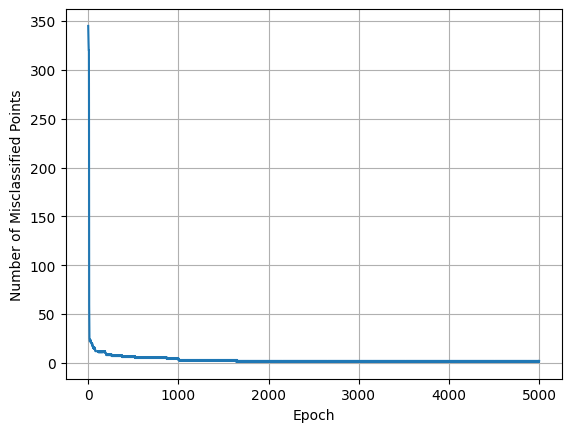

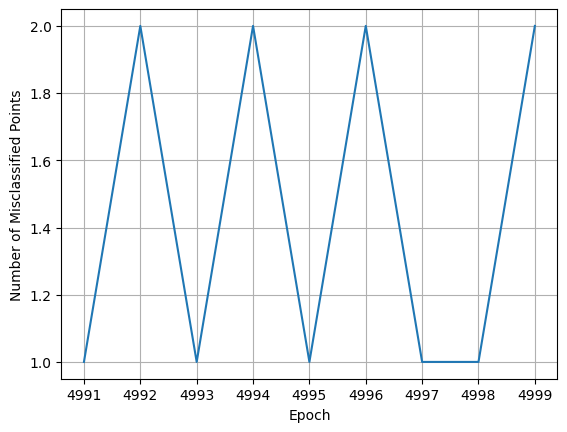

In [110]:
perceptron = PerceptronClassifier(max_iterations=5000)
perceptron.fit(X_train, y_train)
perceptron.plot_misclassifications()

# plota apenas os 10 últimos itens para mostrar se convergiu ou se oscilou
perceptron.plot_misclassifications(start_index=-10)

#### Funções auxiliares para análise do classificador:

In [111]:
perceptron.get_weights(as_dataframe=True)

,weight,value
0,w0,1.168393
1,w1,0.630858
2,w2,-0.546236


## Desenvolvimento do estimador: